## Project Control

This notebook should have been deployed in Watson Studio
    **but** unfortunately Watson Studio doesn't support interactive notebooks yet

Git Repos to be investigated:

* https://github.ibm.com/wiotp/monitoring-dashboard
* https://github.ibm.com/wiotp/analytics-service


### Github Analyzer

This notebook should have been deployed in Watson Studio
    **but** unfortunately Watson Studio doesn't support interactive notebooks yet

Git Repos to be investigated:

* https://github.ibm.com/wiotp/monitoring-dashboard
* https://github.ibm.com/wiotp/analytics-service


Influenced by IBM's Data and AI dev transformation group

<a href="https://github.ibm.com/DataandAI-dev-transformation/dev-transformation/blob/master/code-quality/defect_tracking.MD" target="_blank">DataandAI-dev-transformation - code quality defect tracking</a>

and more specifically the automatic component assigner for new defects [here](https://github.ibm.com/DataandAI-dev-transformation/defect_classification_ml_to_assign_component/blob/master/DefectClassifier_SGD_TFID_features-5.ipynb)

In [1]:
import csv
import requests
import collections
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import cm, table
from mpl_toolkits.mplot3d import axes3d

In [42]:
# custom functions - install with pip install git+https://github.com/sedgewickmm18/mmfunctions
from mmfunctions import gitanalyzer

In [3]:
# Repos and credentials to retrieve the data from
params = {}
params['REPO'] = 'wiotp/monitoring-dashboard'
params['REPO2'] = 'wiotp/analytics-service'
params['REPO_ID'] = 566611
params['REPO2_ID'] = 211664
params['ZENHUB_WORKSPACE'] = '5cd44ce4baded506ba8ddd5f'
params['GITHUB_TOKEN'] = 'ad7e5d3d34e79ac5d06210e74546c36b4bbc86ab'
params['ZENHUB_TOKEN'] = '814960f27921de182e39873816e4a54be9cdbb5000baa92d054e773949c1681e5e637c3bd30b54ad'
params['TRAVIS_TOKEN'] = '7B8mnG99oqNcHJgKKXMYVQ'
params['BASE_URL'] = 'https://github.ibm.com'
params['ZEN_BASE_URL'] = 'https://zenhub.ibm.com'
params['IGNORE_RELEASES'] = ['closed'] # valid parms: closed, rel names

gitanalyzer.process_all(params)
# After extraction store the data in cloud object store

loading zenhub releases
loading zenhub issues per releases
loading zenhub issues by board
Process github repo 1
Process github repo 2


In [4]:
# upload stuff for later use to COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
put monitoring-defects.csv s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in

upload: 'monitoring-defects.csv' -> 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv'  [1 of 1]
 743818 of 743818   100% in    3s   187.60 kB/s  done


In [5]:
# get it back from COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --force --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
get s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv wiotp-monitoring-dashboard-defects.csv

download: 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv' -> 'wiotp-monitoring-dashboard-defects.csv'  [1 of 1]
 535185 of 535185   100% in    1s   267.59 kB/s  done


#### Example Data

Issue data from github and zenhub combined

In [56]:
defects_df = pd.read_csv('./monitoring-defects.csv') # parse_dates=['Created'])

## Remove the encoding prefix string
df=defects_df.replace('b\'','',regex=True).astype(object)
df=df.replace('b\"','',regex=True).astype(object)
df['Created'] = pd.to_datetime(df['Created'])
df['Updated'] = pd.to_datetime(df['Updated'])
df['Closed'] = pd.to_datetime(df['Closed'])

# average estimates for NaN
df['Estimate'] = df['Estimate'].fillna(2.69)
df['Release'] = df['Release'].fillna('')
df['Closed'] = df['Closed'].fillna(pd.Timestamp(gitanalyzer.FarFuture)).dt.round('1d')

# Strip off outdated stuff
df = df[df['Pipeline'] != 'To Be Closed']
df.head(1)

,Title,Repo,Created,Updated,Closed,Origin,Assignee,Status,Release,Milestone,Type,Component,Estimate,BusinessValue,Severity,Risk,Theme,Blocked,Pipeline,Labels
1025,[UX]Support raw data in summary dashboard crea...,wiotp/monitoring-dashboard,2020-05-08 02:18:36,2020-05-08 02:27:42,2030-01-01,cynthiaz,NaN,open,,NaN,Issue,NaN,2.69,0,3,2,NaN,NaN,New Issues,['ui']


In [135]:
# Retrieve release map
df_release = pd.read_csv('./monitoring-releases.csv')
ReleaseMap = df_release['Title'].reset_index()[['Title','index']].to_numpy().tolist()
ReleaseDateMap = df_release.to_numpy().tolist()
#ReleaseDateMap

,Id,Title,Start,DesiredEnd,Closed
0,5cd959e392c9a206d3cfd5da,Monitor April 2020 Release,2019-12-31 00:00:00,2020-04-29 00:00:00,2030-01-01


#### Our journey 

This is obviously a large wish list and not all of the metrics are equally important

![image.png](./images/Ayoa.png)

In [7]:
# Assign some risks random risks
df['Risk'] = np.random.choice([1,2,3], df['Risk'].values.shape[0], p=[0.2, 0.3, 0.5])
#df['Title'] = df['Title'][:5]
#df.head(5)

In [7]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Layout, Button, ToggleButton, Box, Dropdown, Text, Textarea
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from ipywidgets import Output

#w = widgets.IntSlider()
#display(w)

#### Split up issues by type and severity

In [8]:
df['Color'] = '#ffcc99'
#df[df['Type'] == 'Issue']['Color'] = '#ff9999'
#df[df['Type'] == 'Bug']['Color'] = '#66b3ff'
#df[df['Type'] == 'Epic']['Color'] = '#99ff99'

dfs = [df[df['Severity'] == 1], df[df['Severity'] == 2], df[df['Severity'] == 3], 
       df[df['Severity'] == 4], df]
dfssum = []

# prepare data
cnt = []
labels = []
explode = []
colors = []

for dfs_el in dfs:
    cnt_el = dfs_el.groupby('Type')['Title'].count()
    dfssum.append('Sum: ' + str(dfs_el.count()['Title']))
    labels.append(cnt_el.index)
    explode.append(np.zeros(cnt_el.size) + 0.02)
    #colors.append(cnt_el['Color'])
    cnt.append(cnt_el)
    
# define widget
box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='23%')
dropdown = Dropdown(
    options=[('sev1', 0), ('sev2', 1), ('sev3',2), ('sev4',3), ('sev 1 to 4', 4), ('all', 11)],
    value=11,
    description='Severity:',
)
box = Box(children=[dropdown], layout=box_layout)
    
def f(severity):
    if severity > 10:
        fig, ax = plt.subplots(1, 5, figsize=(20,6))
        for i in [0,1,2,3,4]:
            ax[i].pie(cnt[i], explode=explode[i], labels=labels[i], autopct='%1.1f%%',
                      shadow=True, startangle=90)
            if i < 4:
                ax[i].set_title('Monitoring issues by Type\n   Severity: ' + str(i + 1))

            else:
                ax[i].set_title('Monitoring issues by Type\n   All severities')
            ax[i].text(-1.1,1,dfssum[i],ha='center',va='center',fontsize=12, 
                       bbox=dict(facecolor='beige', alpha=0.5))
    else:
        fig1, ax1 = plt.subplots()
        ax1.pie(cnt[severity], explode=explode[severity], labels=labels[severity], autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        if severity < 4:
            ax1.set_title('Monitoring issues by Type\n   Severity: ' + str(severity + 1))
        else:
            ax1.set_title('Monitoring issues by Type\n   All severities')
        ax1.text(-1.1,1,dfssum[severity],ha='center',va='center',fontsize=12, 
                       bbox=dict(facecolor='beige', alpha=0.5))

ws = interactive_output(f, {'severity': dropdown});
display(box, ws)

Box(children=(Dropdown(description='Severity:', index=5, options=(('sev1', 0), ('sev2', 1), ('sev3', 2), ('sev…

Output()

### Velocities

- Overall Velocity
- Defect Velocity (**implemented** - starting mid 2019)
- Customer satisfaction (**no data** not included as we have no data)
- Defect breakdown by severity (**no data** we have no severities in our defects)
- Value per sprint (**no data** value of epics or stories is not known)
- Percentage of test case coverage (**no data** - we do not track that)
- Customer Support Requests (**no data*)
- Trends (let's define what trends we need)
- NPS (**no data**)
- Build failures (need to get Travis data)
- Deployment failures (Jenkins ?)
- Technical Debts (**no data** we need a label)

#### Issue velocity

In [9]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


dfv = df.copy()
# replace NaT with now
dfv['Closed'] = dfv['Closed'].fillna(pd.Timestamp.now())
#dfv = dfv[dfv['Status'] == 'closed']

dfv = dfv[dfv['Created'] > StartWith]
dfv['Age_in_weeks'] = dfv['Closed'] - dfv['Created'] + pd.Timestamp('2020-01-01')
dfv = dfv[['Severity', 'Status', 'Type', 'Age_in_weeks']].set_index(['Type','Status'])



dfvs = [dfv[dfv['Severity'] == 1], dfv[dfv['Severity'] == 2],
        dfv[dfv['Severity'] == 3], dfv[dfv['Severity'] == 4], dfv]

cntv = []
for dfs_el in dfvs:
    cnt_el = dfs_el.groupby(['Status', 'Type', dfs_el['Age_in_weeks'].dt.week]).count().drop(columns='Age_in_weeks')
    cnt_el = cnt_el.reset_index().set_index('Age_in_weeks')
    #print (cnt_el)
    cntv.append(cnt_el)

StatusMap = [('open', 0), ('closed', 1), ('All',2)]
TypeMap = [('Issue', 0), ('Bug', 1), ('Epic',2), ('All', 3)]

IMAX = 11
emptydf = pd.DataFrame({'Age_in_weeks' : [IMAX], 'Severity': [0.001]}).set_index('Age_in_weeks')

def projection(sev, stat, typ):
    cntvp = []
    for cntv_el in cntv:
        if typ < 3:
            cntv_el = cntv_el[cntv_el['Type'] == TypeMap[typ][0]]   
        if stat < 2:
            cntv_el = cntv_el[cntv_el['Status'] == StatusMap[stat][0]]

        if cntv_el.index.size > 0 or cntv_el.index.max() < IMAX:
            cntv_el = cntv_el.append(emptydf)
            #print(cntv_el)
            

        cntvp.append(cntv_el)
    return cntvp
    
#print (cntv[0])
# define widget
box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='65%')
dropdown = Dropdown(
    options=[('sev1', 0), ('sev2', 1), ('sev3',2), ('sev4',3), ('sev 1 to 4', 4), ('all', 11)],
    value=11,
    description='Severity:',
)
dropdown2 = Dropdown(
    options=StatusMap,
    value=1,
    description='Status:',
)
dropdown3 = Dropdown(
    options=TypeMap,
    value=3,
    description='Type:',
)
box = Box(children=[dropdown,dropdown2, dropdown3], layout=box_layout)

def f(severity, status, Type):
    #df_vel = df_velocity.copy()
    cntvp = projection(severity, status, Type)
    if severity > 10:
        fig, ax = plt.subplots(1, 5, figsize=(20,3))
        for i in [0,1,2,3,4]:
            ax[i].bar(cntvp[i].index, cntvp[i]['Severity'].values)
            if i < 4:
                ax[i].set_title('Monitoring issues aging\n   Severity: ' + str(i + 1))
            else:
                ax[i].set_title('Monitoring issues aging\n   All severities')
            ax[i].set_xlabel('Age in weeks')
    else:
        fig1, ax1 = plt.subplots(figsize=(7,3))
        ax1.bar(cntvp[severity].index, cntvp[severity]['Severity'].values)
        if severity < 4:
            ax1.set_title('Monitoring issues aging\n   Severity: ' + str(severity + 1))
        else:
            ax1.set_title('Monitoring issues aging\n   All severities')
        ax1.set_xlabel('Age in weeks')

ws = interactive_output(f, {'severity': dropdown, 'status': dropdown2, 'Type': dropdown3});
display(box, ws)

Box(children=(Dropdown(description='Severity:', index=5, options=(('sev1', 0), ('sev2', 1), ('sev3', 2), ('sev…

Output()

#### Open epics - risks vs value

Text(0.5, 1.0, 'Heatmap of open Epics\n by value and risk')

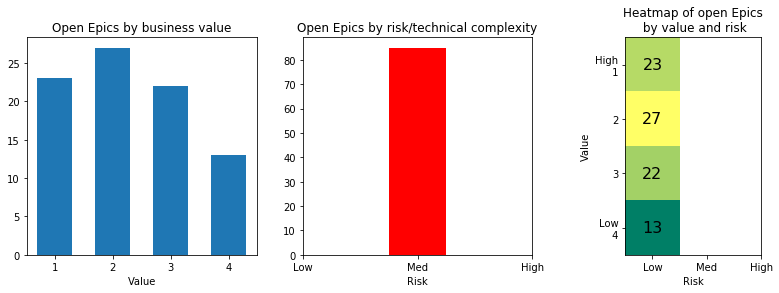

In [10]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


df_val = df.copy()
df_val = df_val[df_val['BusinessValue'] > 0]
df_val['Risk'] += 1
df_val = df_val[df_val['Status'] == 'open'][['BusinessValue','Risk', 'Title']]
fig, ax = plt.subplots(1, 3, figsize=(14,4))
val_el = df_val.groupby(df_val['BusinessValue']).count()
risk_el = df_val.groupby(df_val['Risk']).count()
valrisk_el = df_val.groupby(['BusinessValue','Risk']).size()
valrisk_grid = valrisk_el.unstack().to_numpy()

ax[0].bar(val_el.index, val_el['Title'].values, width=0.6)
ax[0].set_title('Open Epics by business value')
ax[0].set_xlabel('Value')
ax[0].set_xticks([1,2,3,4])
#ax[1].set_xticklabels(['Low','Med','High'])


ax[1].bar(risk_el.index, risk_el['Title'].values, color='red', width=0.5)
ax[1].set_title('Open Epics by risk/technical complexity')
ax[1].set_xlabel('Risk')
ax[1].set_xticks([2,3,4])
ax[1].set_xticklabels(['Low','Med','High'])

ax[2].imshow(valrisk_grid, interpolation ='none', cmap='summer')
for (j,i),label in np.ndenumerate(valrisk_grid):
    if np.isnan(label):
        label = '0'
    else:
        label = int(label)
    ax[2].text(i,j,label,ha='center',va='center',fontsize=16)

ax[2].set_xlabel('Risk')
ax[2].set_xticks([0,1,2])
ax[2].set_xticklabels(['Low','Med','High'])
ax[2].set_ylabel('Value')
ax[2].set_yticks([0,1,2,3])
ax[2].set_yticklabels(['High\n 1',2,3,'Low\n 4'])
#ax[2].set_yticks([1,2,3,4,5])
ax[2].set_title('Heatmap of open Epics\n by value and risk')


### Initiatives, Epics, Stories

- Epics per Initiatives (not 
- Initiative completion by percentage
- Percentage of Epics completed
- Percentage of stories completed by sprint vs what was committed
- Defects per story
- End to end start to completion average

In [11]:
# Open vs closed epics

def f(Date):
    df_epics = df[df['Type'] == 'Epic']   
    df_epics = df_epics[df_epics['Created'] > Date]
    df_epics = df_epics[['Status', 'Type']]
    length = 20 * df_epics.index.size / 200
    df_epics.groupby(df_epics['Status']).count().plot(figsize=(length,2), kind='barh', legend=False)
    plt.title('Epics by completion \n created after ' + Date)

interact(f, Date=[('Jul 2019', '2019-06-30'), ('Oct 2019', '2019-09-30'), ('Jan 2020', '2019-12-31'), 
                  ('Feb 2020','2020-01-31'), ('Mar 2020', '2020-02-28'), ('Apr 2020','2020-03-31')])

interactive(children=(Dropdown(description='Date', options=(('Jul 2019', '2019-06-30'), ('Oct 2019', '2019-09-…

<function __main__.f>

In [27]:
# Todo: load from github/zenhub
SprintMap = [['Release 2 Sprint 1', 1], ['Release 2 Sprint 2', 2],
             ['Release 2 Sprint 3', 3], ['Release 2 Sprint 4', 4],
             ['Release 2 Sprint 5', 5], ['Release 2 Sprint 6', 6],
             ['Release 2 Sprint 7', 7], ['Release 2 Sprint 8', 8],
             ['Release 2 Sprint 9', 9], ['Release 2 Sprint 10', 10],
             ['March 2020 Sprint 11', 11], ['March 2020 Sprint 12', 12],
             ['April 2020 Sprint 13', 13], ['April 2020 Sprint 14', 14],
             ['May 2020 - Sprint 15', 15], ['May 2020 - Sprint 16', 16],
             ['May 2020 - Sprint 17', 17]]
              
DateMap = [('2019-09-26', '2019-10-15'), ('2019-10-16', '2019-10-24'),  # sprints 1,2
           ('2019-10-25', '2019-11-07'), ('2019-11-08', '2019-11-22'),
           ('2019-11-23', '2019-12-12'), ('2019-12-13', '2020-01-09'),  # sprints 5,6
           ('2020-01-10', '2020-01-16'), ('2020-01-17', '2020-02-05'),
           ('2020-02-06', '2020-02-13'), ('2020-02-14', '2020-02-27'),  # sprints 9,10
           ('2020-02-28', '2020-03-12'), ('2020-03-13', '2020-03-25'),
           ('2020-03-26', '2020-04-08'), ('2020-04-09', '2020-04-22'),  # sprints april
           ('2020-04-23', '2020-05-06'), ('2020-05-07', '2020-05-20'),
           ('2020-05-21', '2020-06-02')]  # sprint 17

def findSprint(date=None):
    if date is None:
        td = pd.Timestamp.today()
    else: td = date
    for i,dat in zip(range(100),DateMap):
        # end date later than today
        if pd.to_datetime(dat[1]) >= td:
            return i
    return -1  # not found
        

FromMap = [('now', 1)]
LookbackMap = [('this sprint', 0), ('last sprint', 1), ('last 2 sprints', 2), ('last 3 sprints', 3),
           ('last quarter', 12), ('release', 100)]

TypeMap = [('Issue', 0), ('Bug', 1), ('Epic',2), ('All', 3)]

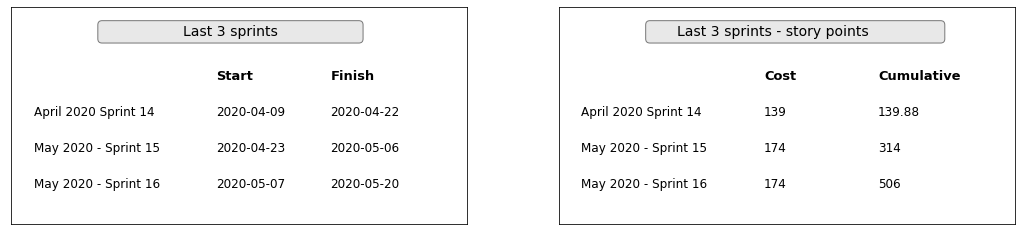

Box(children=(Dropdown(description='End:', options=(('now', 1),), value=1), Dropdown(description='Lookback:', …

Output()

In [38]:
# Burnup
StartDate = '2020-01-01' # start with sprint 7
Type = 2 # only Epics
pd.options.mode.chained_assignment = None

box_layoutB = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='100%')
dropdate = Dropdown(
    options=FromMap,
    value=1,
    description='End:',
)
droplookback = Dropdown(
    options=LookbackMap,
    value=1,
    description='Lookback:',
)
dropType = Dropdown(
    options=TypeMap,
    value=3,
    description='Type:',
)
showEpics = ToggleButton(
    value=False,
    description='Epics:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

boxB = Box(children=[dropdate, droplookback, dropType, showEpics], layout=box_layoutB)

i = findSprint()
df_points = df.copy()
# Assume estimate is at least 1 if nothing is specified
df_p1 = df[df['Milestone'] == SprintMap[i-2][0]][['Estimate','Type']].fillna(1)
df_p2 = df[df['Milestone'] == SprintMap[i-1][0]][['Estimate','Type']].fillna(1)
df_p3 = df[df['Milestone'] == SprintMap[i][0]][['Estimate','Type']].fillna(1)

df_p1['Estimate'].sum()

boxprops2 = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
figout, axout = plt.subplots(1, 2, figsize=(18,4))
axout[0].set(xlim=(0,4), ylim=(0,3))
axout[0].get_yaxis().set_visible(False)
axout[0].get_xaxis().set_visible(False)

axout[0].text(0.8, 2.6, '                  Last 3 sprints                  ', fontsize=14, bbox=boxprops2)

axout[0].text(0.2, 0.5, SprintMap[i][0], fontsize=12)
axout[0].text(0.2, 1, SprintMap[i-1][0], fontsize=12)
axout[0].text(0.2, 1.5, SprintMap[i-2][0], fontsize=12) 
axout[0].text(1.8, 2, 'Start', fontsize=13, fontweight='bold')
axout[0].text(1.8, 0.5, DateMap[i][0], fontsize=12)
axout[0].text(1.8, 1, DateMap[i-1][0], fontsize=12)
axout[0].text(1.8, 1.5, DateMap[i-2][0], fontsize=12) 
axout[0].text(2.8, 2, 'Finish', fontsize=13, fontweight='bold')
axout[0].text(2.8, 0.5, DateMap[i][1], fontsize=12)
axout[0].text(2.8, 1, DateMap[i-1][1], fontsize=12)
axout[0].text(2.8, 1.5, DateMap[i-2][1], fontsize=12) 

axout[1].get_yaxis().set_visible(False)
axout[1].get_xaxis().set_visible(False)
axout[1].set(xlim=(0,4), ylim=(0,3))

axout[1].text(0.8, 2.6, '      Last 3 sprints - story points                ',
                fontsize=14, bbox=boxprops2)

axout[1].text(0.2, 0.5, SprintMap[i][0], fontsize=12)
axout[1].text(0.2, 1, SprintMap[i-1][0], fontsize=12)
axout[1].text(0.2, 1.5, SprintMap[i-2][0], fontsize=12) 
axout[1].text(1.8, 2, 'Cost', fontsize=13, fontweight='bold')
axout[1].text(1.8, 0.5, int(df_p2['Estimate'].sum()), fontsize=12)
axout[1].text(1.8, 1, int(df_p2['Estimate'].sum()), fontsize=12)
axout[1].text(1.8, 1.5, int(df_p1['Estimate'].sum()), fontsize=12) 
axout[1].text(2.8, 2, 'Cumulative', fontsize=13, fontweight='bold')
axout[1].text(2.8, 1.5, df_p1['Estimate'].sum(), fontsize=12)
axout[1].text(2.8, 1, int(df_p1['Estimate'].sum() + df_p2['Estimate'].sum()), fontsize=12)
axout[1].text(2.8, 0.5, int(df_p1['Estimate'].sum() + df_p2['Estimate'].sum() + df_p3['Estimate'].sum()),
              fontsize=12) 


def f_burnup(EndDate, Lookback, Type, ShowEpics):
    # print(EndDate, Lookback)
    if EndDate == 1:
        EndDate = pd.Timestamp.today()
    if Lookback == 100:
        Lookback = 180
        
    StartDate = pd.to_datetime(EndDate) - dt.timedelta(days=Lookback*14)
    #firstmile = findSprint(StartDate)
    lastmile = findSprint(EndDate)
    firstmile = lastmile - Lookback
    # print (StartDate)
    #df_burn = df.copy()
    
    #df_burn = df_burn[df_burn['Created'] > StartDate]
    # need: schedule for sprints in StartDate to Enddate
    milelist = SprintMap[firstmile:lastmile]
    milelist = [m[0] for m in milelist]
    # print (Lookback, firstmile, lastmile, milelist)

    df_burn = df.query('Milestone in @milelist').copy()
    
    # Turn NaT into a future date and round to the day
    df_burn['Closed'] = df_burn['Closed'].fillna(pd.Timestamp('2030-01-01')).dt.round('1d')

    # cut out items still open
    df_cut = df_burn[df_burn['Closed'] < '2030-01-01']
    
    # remove types we don't want to see
    if Type != 3:
        df_cut = df_cut[df_cut['Type'] == TypeMap[Type][0]]
  
    # cumulative sum of closed items
    s = pd.to_datetime(df_cut['Closed'])
    dfc = s.groupby(s.dt.floor('d')).size().reset_index(name='count').set_index('Closed')
    dfc['cumsum'] = dfc['count'].cumsum()
    
    dfd = df_burn[df_burn['Type'] == 'Epic'] #.set_index(['Closed']).sort_index()
    #dfd = dfd[dfd['Closed'] < '2030-01-01']
    dfd['Title'] = dfd['Title'].apply(lambda x: x[:50])

    #print (dfd['text'])
    s_all = dfd.groupby(['Closed'])['Title'].apply(lambda x: '\n'.join(x))
    s = s_all[:'2029-12-31']
    still_open = ''
    try:
        still_open = str(s_all['2030-01-01'])
    except Exception:
        pass
    
    proportional = 0.8
    if ShowEpics: proportional = 1
    fig, ax = plt.subplots(1, 1, figsize=(15 * proportional, 12 * proportional), squeeze=False)

    # ignore last value of epics still open
    ax[0,0].plot(dfc[:].index, dfc['cumsum'][:].values, lw=2, color='darkviolet')
    
    # catch cumsum array empty
    try:
        ax[0,0].plot(pd.Timestamp.now(), dfc['cumsum'][-1], lw=2, color='darkviolet')
    except:
        pass
    
    ax[0,0].fill_between(dfc[:].index, dfc['cumsum'][:].values-0.2, color='lightgrey')
    #ax[0,0].fill_between(ages, total_population)
    ax[0,0].set_title('Burn up, long-term view', fontsize=14)

    # print (s)
    if ShowEpics:
        boxprops = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        boxprops3 = dict(boxstyle='round', facecolor='orange', alpha=0.5)
        i = 0
        k = 0
        lastdc = None
        for dc, row in s.iteritems():
            i += 1
            lastdc = dc
            i += 1
            if i % 2: j = -1.7
            else: j = 1.7
            #print(dfd.loc[date_closed,:])
            try:
                y_axis = dfc.loc[dc,:]['cumsum'] + j
            except:
                y_axis = k
                pass

            try:
                ax[0,0].plot(dc, y_axis, lw=0.1)
                ax[0,0].text(dc, y_axis,row, fontsize=8, zorder=10, bbox=boxprops)
                #print(dc, y_axis,row)
            except Exception as e:
                print (str(e))
                pass
        if len(still_open) > 0:
             
            ax[0,0].text(lastdc, 3, 'Epics still open', fontsize=10, zorder=10, fontweight='bold', bbox=boxprops3)
            ax[0,0].text(lastdc, 5, still_open, fontsize=8, zorder=10, bbox=boxprops3)
                
bu_sprint = interactive_output(f_burnup, {'EndDate': dropdate, 'Lookback': droplookback, 
                                          'Type': dropType, 'ShowEpics': showEpics});


display(boxB, bu_sprint)

In [166]:
# Burndown release
StartDate = '2020-01-01' # start with sprint 7
Type = 2 # only Epics
pd.options.mode.chained_assignment = None

box_layoutBR = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='80%')

droprelease = Dropdown(
    options=ReleaseMap,
    value=1,
    description='Release:',
)
dropType = Dropdown(
    options=TypeMap,
    value=3,
    description='Type:',
)
showEpics = ToggleButton(
    value=False,
    description='Epics:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

boxBR = Box(children=[droprelease, dropType, showEpics], layout=box_layoutBR)

def f_burnupR(Release, Type, ShowEpics):
    
    release = ReleaseMap[Release][0]
    EndDate = df_release.query('Title == @release')['DesiredEnd'].to_numpy()[0]

    df_burnr = df[df['Release'] == release]
    
    # remove types we don't want to see
    if Type != 3:
        df_cutr = df_burnr[df_burnr['Type'] == TypeMap[Type][0]]
    else:
        df_cutr = df_burnr
        
    df_cutr = df_cutr.reset_index().set_index('Closed').sort_index()
    
    summing_ = []
    ic_first = None
    ic_second = None
    ic_third = None

    for ic in df_cutr.index:
        if ic_first is None: ic_first = ic
        elif ic_second is None: ic_second = ic
        elif ic_third is None: ic_third = ic
        s = df_burnr.query('Closed <= @ic' and 'Created <= @ic')['Estimate'].sum()
        scr = df_burnr.query('Created <= @ic')['Estimate'].to_numpy().shape[0]
        scl = df_burnr.query('Closed <= @ic')['Estimate'].to_numpy().shape[0]
        summing_.append([s, scr, scl])
    summing = np.asarray(summing_)
    
    df_cutr['cumsum'] = summing[:,0]
    df_cutr['new'] = summing[:,1]
    df_cutr['gone'] = summing[:,2]

    still_open_pts = df_burnr.query('Closed == @gitanalyzer.FarFuture')['Estimate'].sum()
    still_open = df_burnr.query('Closed == @gitanalyzer.FarFuture')['Estimate'].to_numpy().shape[0]
    cum_closed = summing[-1,0]
    # print (still_open)
        
    dfc = df_cutr.reset_index().query('Closed < @gitanalyzer.FarFuture').set_index('Closed')

    proportional = 0.8
    if ShowEpics: proportional = 1
    fig, ax = plt.subplots(1, 1, figsize=(15 * proportional, 12 * proportional))

    # ignore last value of epics still open
    ax.plot(dfc[:].index, dfc['cumsum'][:].values, lw=2, color='darkviolet', 
            zorder=1, label='cumulative by story points')
    ax.plot(dfc[:].index, dfc['new'][:].values-0.5, lw=2, color='blue', zorder=1, label='new items')
    ax.plot(dfc[:].index, dfc['gone'][:].values, lw=2, color='black', zorder=1, label='closed items')
    
    ax.legend()
    
    ax.fill_between(dfc[:].index, dfc['cumsum'][:].values-0.2, color='lightgrey')
    ax.set_title('Burn up per release for \"' + release + '\"', fontsize=14)
    
    boxprops = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    msg = 'Items still open:\n In story points: ' + str(int(still_open_pts)) + '\n By number: ' + str(still_open)
    try:
        ax.text(ic_first, dfc['cumsum'][0], msg, fontsize=10, zorder=10, bbox=boxprops)
    except: pass
    try:
        ax.text(ic_second, dfc['new'][0], 'Issues raised', fontsize=10, zorder=10, bbox=boxprops)
    except: pass
    try:
        ax.text(ic_third, dfc['gone'][0], 'Issues gone', fontsize=10, zorder=10, bbox=boxprops)
    except: pass
    
    if ic_first is not None:
        ax.plot([ic_first, pd.Timestamp(EndDate)],[0,summing[-1,0]], lw=2, ls='dashed', 
                 color='gold', zorder=4, label='projection')
        ax.text(pd.Timestamp(EndDate), summing[-1,0], 'Release End', fontsize=10, zorder=10, bbox=boxprops)

    # print (s)
    if ShowEpics:
        boxprops = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        boxprops3 = dict(boxstyle='round', facecolor='orange', alpha=0.5)
        i = 0
        k = 0
        lastdc = None
        for dc, row in s.iteritems():
            i += 1
            lastdc = dc
            i += 1
            if i % 2: j = -1.7
            else: j = 1.7
            #print(dfd.loc[date_closed,:])
            try:
                y_axis = dfc.loc[dc,:]['cumsum'] + j
            except:
                y_axis = k
                pass

            try:
                ax[0,0].plot(dc, y_axis, lw=0.1)
                ax[0,0].text(dc, y_axis,row, fontsize=8, zorder=10, bbox=boxprops)
                #print(dc, y_axis,row)
            except Exception as e:
                print (str(e))
                pass
        if len(still_open) > 0:
             
            ax[0,0].text(lastdc, 3, 'Epics still open', fontsize=10, zorder=10, fontweight='bold', bbox=boxprops3)
            ax[0,0].text(lastdc, 5, still_open, fontsize=8, zorder=10, bbox=boxprops3)
                
bu_sprintR = interactive_output(f_burnupR, {'Release': droprelease, 'Type': dropType, 'ShowEpics': showEpics});


display(boxBR, bu_sprintR)

Box(children=(Dropdown(description='Release:', index=1, options=(['Monitor April 2020 Release', 0], ['Monitor …

Output()

#### Next steps

- Aggregate data over smaller time spans such as **sprints** to get insights in velocity and completion rate
- Pull in data from travis and jenkins to include build process quality metrics


In [15]:


box_layoutS = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='45%')
dropsprint = Dropdown(
    options=SprintMap,
    value=14,
    description='Sprint:',
)
droptype = Dropdown(
    options=TypeMap,
    value=1,
    description='Type:',
)
boxS = Box(children=[dropsprint, droptype], layout=box_layoutS)




def f_sprint(Sprint, Type):
    # get all stories of given type closed in this sprint 
    if Type != 3:
        df_sprint = df[df['Type'] == TypeMap[Type][0]]
    else:
        df_sprint = df.copy()
    
    print (Sprint)
    # Sprint start is in the past - use closed date
    #if pd.Timestamp(DateMap[Sprint][0]) < dt.datetime.now():
    #    df_sprint = df_sprint[DateMap[Sprint][0]<= df_sprint['Closed']]
    #    df_sprint = df_sprint[df_sprint['Closed'] <= DateMap[Sprint][1]]
    #else: # use planned date
    df_sprint = df_sprint[df_sprint['Milestone'] == SprintMap[Sprint-1][0]]
    #print (df_sprint[['Title','Closed','Milestone']])
    df_sprint['Closed'] = df_sprint['Closed'].fillna(pd.Timestamp('2030-01-01'))
    
    df_sprint['Sized'] = pd.isna(df_sprint['Estimate'].values)   
    df_sizes = df_sprint.groupby(df_sprint['Sized']).count()    
    df_value = df_sprint.groupby(df_sprint['BusinessValue']).count()
    
    s = pd.to_datetime(df_sprint['Closed'])
    #dfc = df_sprint[df_sprint['Closed'] <= DateMap[Sprint-1][0]].reset_index().set_index(['Closed'])
    dfc = df_sprint[df_sprint['Closed'] < '2030-01-01'].reset_index().set_index(['Closed'])
    #print(dfc)
    
    #print (dfc)
    dfc = s.groupby(s.dt.floor('d')).size().reset_index(name='count').set_index('Closed')
    #print(dfc)
    dfc['cumsum'] = dfc['count'].cumsum()
    print(dfc)
    dfc['burndown'] = len(df_sprint.index) - dfc['cumsum']
    
    dfd = dfb[dfb['Closed'] < '2030-01-01'].set_index(['Closed'])
    
    #print(df_sprint[['Title', 'BusinessValue']])
    
    fig, ax = plt.subplots(1, 2, figsize=(14,2))
    ax[0].barh(df_sizes.index, df_sizes['Title'].values, height=0.3, color='green')
    #ax[0].set_title('Open Epics by business value')
    ax[0].set_ylabel('Sized Items')
    if len(df_sizes['Title']) == 0 or max(df_sizes['Title'].values) < 3:
        ax[0].set_xticks(np.arange(0,3))
    
    ax[0].set_yticks([0, 1])
    ax[0].set_yticklabels(['Sized','Unsized'])
    ax[0].set_title('Sized vs unsized items')
    
    ax[1].barh(df_value.index, df_value['Risk'].values, height=0.4, color='blue')
    #ax[1].set_ylabel('Value per Sprint')
    if len(df_value['Risk']) == 0 or max(df_value['Risk'].values) < 3:
        ax[1].set_xticks(np.arange(0,3))
    ax[1].set_yticks([0, 1, 2, 3, 4])  
    ax[1].set_yticklabels(['Unknown', 'High', 2, 3, 'Low'])
    ax[1].set_title('Value per sprint')

    fig2, ax2 = plt.subplots(1, 2, figsize=(20, 5))
    # ignore last value of epics still open
    ax2[0].plot(dfc[:-1].index, dfc['cumsum'][:-1].values, lw=2, color='darkviolet')
    ax2[0].set_title('Burn up: Type ' + TypeMap[Type][0] + ', Sprint ' + SprintMap[Sprint-1][0], fontsize=14)
    ax2[1].plot(dfc[:-1].index,  dfc['burndown'][:-1], lw=2, color='darkviolet')
    ax2[1].set_title('Burn down: Type ' + TypeMap[Type][0] + ', Sprint ' + SprintMap[Sprint-1][0], fontsize=14)

ws_sprint = interactive_output(f_sprint, {'Sprint': dropsprint, 'Type': droptype});
display(boxS, ws_sprint)

Box(children=(Dropdown(description='Sprint:', index=13, options=(('Release 2 Sprint 1', 1), ('Release 2 Sprint…

Output()

In [124]:
# select only Epics
Type = 2
df_sprints = []
df_sizes = []
df_values = []
for i,sprint,date in zip(range(len(SprintMap)),SprintMap, DateMap):
            
    if pd.Timestamp(DateMap[i][0]) < dt.datetime.now():
        df_spr = df[DateMap[i][0]<= df['Closed']]
        df_spr = df_spr[df_spr['Closed'] <= DateMap[i][1]]
    else: # use planned date
        df_spr = df_spr[df_spr['Milestone'] == SprintMap[i][0]]
    df_spr['Sized'] = pd.isna(df_spr['Estimate'].values)
    
    # project Type
    if Type != 3:
        df_spr = df_spr[df_spr['Type'] == TypeMap[Type][0]]
    
    df_sprints.append(df_spr)
    df_siz = df_spr.groupby(df_spr['Sized']).count()  
    df_sizes.append(df_siz)
    df_val = df_spr.groupby(df_spr['Closed'].dt.day)['Estimate'].cumsum()
    df_values.append(df_val)
    
df_epics = df_values[12]
#df_epics = df_epics[df_epics['Type'] == 'Epic']
df_epics
    
#fig, ax = plt.subplots(1, 1, figsize=(20, 30))
#for i in range(9, len(SprintMap)):
#    ax.bar(df_values[i].index + 10 * i, df_values[i]['Risk'].values, width=0.3, color='blue')
  

DataError: No numeric types to aggregate

#### Longer term considerations

##### Should we continue with a local Jupyter notebook or invest in a dashboard ?

Maybe we make use of Jupyter and quick prototyping until we have 80% of the metrics in place we need. 